# Análise Exploratória de Dados - Loggi



## 1\. Introdução

Para este projeto foi utilizado o banco de dados Loggi, startup brasileira de logística. Loggi é uma startup brasileira unicórnio de tecnologia com foco principal em logística. Iniciou suas operações em 2013, inicialmente cuidando da entrega de documentos. Ao longo de dois anos, expandiu seus serviços para incluir o setor de comércio eletrônico. Desde 2017, a Loggi também atua na entrega de alimentos.

O conjunto de dados foi adquirido através do GitHub do repositório Loggi Benchmark for Urban Deliveries (BUD). Este repositório contém dados e códigos relacionados a desafios típicos enfrentados por empresas de logística, como otimizar rotas de entrega e alocar entregas a uma frota com capacidade limitada. É representativo dos desafios que a startup enfrenta no dia a dia, principalmente no que diz respeito à sua escala.

Os dados utilizados para esse projeto são refentes às entregas da capital Rio Janeiro e regiões próximas. Essas informações estão disponibilzadas [aqui](https://github.com/loggi/loggibud/blob/master/docs/quickstart.md). Os dados brutos estão distribuídos em arquivos do tipo JSON com uma lista de instâncias de entregas. Cada instância representa um conjunto de entregas que devem ser realizadas pelos veículos do hub regional. Exemplo:




```
# {
    "name": "cvrp-0-rj-0",
    "region": "rj-0",
    "origin": {"lng": -43.09887838388887, "lat": -22.866229814964015}, "vehicle_capacity": 180,
    "deliveries": [
      {
        "id": "8f6abd1e06bd7704feac404a445094e1",
        "point": {
          "lng": -43.10803774439438,
          "lat": -22.863610319183422
          },
        "size": 3
      },
      {
        "id": "e394f05d92650ed1512dabaadc9295d5",
        "point": {
          "lng": -43.08997527513803,
          "lat": -22.862208238855914
          },
          "size": 8
      },
      ...
    ]
  }


```



Onde:

 - **name**: uma `string` com o nome único da instância;
 - **region**: uma `string` com o nome único da região do **hub**;
 - **origin**: um `dict` com a latitude e longitude da região do **hub**;
 - **vehicle_capacity**: um `int` com a soma da capacidade de carga dos **veículos** do **hub**;
 - **deliveries**: uma `list` de `dict` com as **entregas** que devem ser realizadas.


 Sendo que :

 - **id**: uma `string` com o id único da **entrega**;
 - **point**: um `dict` com a latitude e longitude da **entrega**;
 - **size**: um `int` com o tamanho ou a carga que a **entrega** ocupa no **veículo**.

## 2\. Pacotes e bibliotecas

In [ ]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import geopy.distance
import geopandas


## 3\. Processando os dados

Para começar, precisamos consolidar todos os dados em um único DataFrame. Para isso, a medida que lemos cada arquivo do conjunto de dados, adicionamos as informações desse arquivo em uma nova linha do DataFrame por meio da concatenação. Nesse processo, como valor da chave "origin" é um dicionário, também foi necessário realizar a normalização desses dados.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.DataFrame()

for i in range(0,6):
  for j in range(1,90):
    with open(f'/content/drive/MyDrive/RJ - cvrp/rj-{i}/cvrp-{i}-rj-{j}.json', mode='r', encoding='utf8') as file:
      data = json.load(file)
      data_df = pd.json_normalize(data)
      df = pd.concat([df,data_df])
df = df.reset_index(drop = True)

Visualizando o DataFrame que obtemos:

In [ ]:
df

,name,region,vehicle_capacity,deliveries,origin.lng,origin.lat
0,cvrp-0-rj-1,rj-0,180,"[{'id': '8b8564f71cae1f769e2cf3054ccf7d9e', 'p...",-43.098878,-22.866230
1,cvrp-0-rj-2,rj-0,180,"[{'id': 'f0faab25a837cd0e4fbc2db2221f67a1', 'p...",-43.098878,-22.866230
2,cvrp-0-rj-3,rj-0,180,"[{'id': 'ba39fd9cbd6887060dc75118340de698', 'p...",-43.098878,-22.866230
3,cvrp-0-rj-4,rj-0,180,"[{'id': '99adfa99f7d1435801666c0d4400c3ba', 'p...",-43.098878,-22.866230
4,cvrp-0-rj-5,rj-0,180,"[{'id': 'bf802a236f07556939fb80d1b958386c', 'p...",-43.098878,-22.866230
...,...,...,...,...,...,...
529,cvrp-5-rj-85,rj-5,180,"[{'id': '61febaa33906eaf59f2bd48ac4b93e9b', 'p...",-43.348890,-23.005796
530,cvrp-5-rj-86,rj-5,180,"[{'id': '6ec26933120698d5b489dc04337b1b81', 'p...",-43.348890,-23.005796
531,cvrp-5-rj-87,rj-5,180,"[{'id': 'c4ec3921aa4a36783835fabae6c12c16', 'p...",-43.348890,-23.005796
532,cvrp-5-rj-88,rj-5,180,"[{'id': '9aa031bfe7599011e504cc864ce4460', 'po...",-43.348890,-23.005796


Assim, conseguimos um DataFrame onde cada linha representa um conjunto de entrega. Porém desejamos analisar as entregas de maneira individual. Para isso precisaremos utilizar o método `explode` para transformar cada elemento da lista em deliveries uma linha de um DataFrame




In [ ]:
deliveries_exploded_df = df[["deliveries"]].explode("deliveries")
deliveries_exploded_df.head()

deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}), #
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)

deliveries_normalized_df.head()

,delivery_size,delivery_lng,delivery_lat
0,2,-43.096387,-22.851641
0,8,-43.106508,-22.860389
0,6,-43.089468,-22.860232
0,1,-43.098670,-22.859350
0,6,-43.089254,-22.853951


In [ ]:
deliveries = pd.merge(df ,deliveries_normalized_df ,left_index = True, right_index= True, how = 'inner' )
deliveries.head()

,name,region,vehicle_capacity,deliveries,origin.lng,origin.lat,delivery_size,delivery_lng,delivery_lat
0,cvrp-0-rj-1,rj-0,180,"[{'id': '8b8564f71cae1f769e2cf3054ccf7d9e', 'p...",-43.098878,-22.86623,2,-43.096387,-22.851641
0,cvrp-0-rj-1,rj-0,180,"[{'id': '8b8564f71cae1f769e2cf3054ccf7d9e', 'p...",-43.098878,-22.86623,8,-43.106508,-22.860389
0,cvrp-0-rj-1,rj-0,180,"[{'id': '8b8564f71cae1f769e2cf3054ccf7d9e', 'p...",-43.098878,-22.86623,6,-43.089468,-22.860232
0,cvrp-0-rj-1,rj-0,180,"[{'id': '8b8564f71cae1f769e2cf3054ccf7d9e', 'p...",-43.098878,-22.86623,1,-43.098670,-22.859350
0,cvrp-0-rj-1,rj-0,180,"[{'id': '8b8564f71cae1f769e2cf3054ccf7d9e', 'p...",-43.098878,-22.86623,6,-43.089254,-22.853951


In [ ]:
deliveries = deliveries[['region', 'origin.lng', 'origin.lat','vehicle_capacity' , 'delivery_size', 'delivery_lng', 'delivery_lat']].reset_index(drop=True) #descarte das colunas deliveries e name
deliveries

,region,origin.lng,origin.lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,rj-0,-43.098878,-22.866230,180,2,-43.096387,-22.851641
1,rj-0,-43.098878,-22.866230,180,8,-43.106508,-22.860389
2,rj-0,-43.098878,-22.866230,180,6,-43.089468,-22.860232
3,rj-0,-43.098878,-22.866230,180,1,-43.098670,-22.859350
4,rj-0,-43.098878,-22.866230,180,6,-43.089254,-22.853951
...,...,...,...,...,...,...,...
2559285,rj-5,-43.348890,-23.005796,180,2,-43.337337,-23.008857
2559286,rj-5,-43.348890,-23.005796,180,6,-43.335533,-23.003485
2559287,rj-5,-43.348890,-23.005796,180,5,-43.340334,-23.005312
2559288,rj-5,-43.348890,-23.005796,180,6,-43.343775,-23.009221


## 4\. Adicionando informações

### 1\. Adicionando informações de distância (origin - delivery)

Tendo os dados de geolocalização dos hubs de origem e dos destinos dos deliveries é possível calcular a distância entre esses pontos e verificar se um delivery está designado ou não para o hub mais próximo.

In [ ]:
distancias = pd.DataFrame()

In [ ]:
for i in range(0,6):
  lista = list()
  hub_lat = list(deliveries.query(f'region == "rj-{i}"')['origin.lat'])[0]
  hub_lng = list(deliveries.query(f'region == "rj-{i}"')['origin.lng'])[0]
  for j in range(0,2559290):
    lista.append(round((geopy.distance.geodesic((hub_lat, hub_lng),(deliveries['delivery_lat'][j], deliveries['delivery_lng'][j])).km),2)) # calculo da distancia entre hub e destino da entrega
  distancias[ f"dist_rj-{i}"] = lista


In [ ]:
distancias = pd.merge(distancias,deliveries['region'], left_index=True, right_index= True)

In [ ]:
lista = list()
for i in range(0,2559290):
  dist_hub = pd.to_numeric(distancias.iloc[i].drop(['region'])).idxmin()
  hub = dist_hub[5:9]
  lista.append(hub)
distancias[f"nearest_hub"] = lista

In [ ]:
deliveries_dist = pd.merge(deliveries.drop(['region'], axis=1), distancias, how= 'inner' ,left_index=True, right_index=True)

Construímos, dessa forma, um DataFrame com as distâncias de cada destino para os hubs e também uma coluna com o hub mais perto do destino de cada delivery.

In [ ]:
deliveries_dist.head()

,origin.lng,origin.lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,dist_rj-0,dist_rj-1,dist_rj-2,dist_rj-3,dist_rj-4,dist_rj-5,region,nearest_hub
0,-43.098878,-22.86623,180,2,-43.096387,-22.851641,1.64,27.55,49.06,15.38,16.56,31.02,rj-0,rj-0
1,-43.098878,-22.86623,180,8,-43.106508,-22.860389,1.02,26.70,47.92,13.97,15.22,29.62,rj-0,rj-0
2,-43.098878,-22.86623,180,6,-43.089468,-22.860232,1.17,28.42,49.66,15.19,16.85,31.11,rj-0,rj-0
3,-43.098878,-22.86623,180,1,-43.098670,-22.859350,0.76,27.47,48.73,14.59,16.01,30.36,rj-0,rj-0
4,-43.098878,-22.86623,180,6,-43.089254,-22.853951,1.68,28.32,49.76,15.69,17.13,31.50,rj-0,rj-0


### 2\. Adicionando POINT para uso de visualizações com Geopandas

In [ ]:
#HUB POINTS

hub_df = deliveries[["region", "origin.lng", "origin.lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_rj = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["origin.lng"], hub_df["origin.lat"]))
geo_hub_rj.head()

,region,origin.lng,origin.lat,geometry
0,rj-0,-43.098878,-22.866230,POINT (-43.09888 -22.86623)
1,rj-1,-43.361487,-22.812536,POINT (-43.36149 -22.81254)
2,rj-2,-43.570792,-22.906716,POINT (-43.57079 -22.90672)
3,rj-3,-43.195760,-22.955662,POINT (-43.19576 -22.95566)
4,rj-4,-43.243168,-22.913911,POINT (-43.24317 -22.91391)


In [ ]:
#DELIVERIES POINTS

geo_deliveries_rj = geopandas.GeoDataFrame(deliveries_dist, geometry = geopandas.points_from_xy(deliveries["delivery_lng"], deliveries["delivery_lat"]))
geo_deliveries_rj.head()

,origin.lng,origin.lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,dist_rj-0,dist_rj-1,dist_rj-2,dist_rj-3,dist_rj-4,dist_rj-5,region,nearest_hub,geometry
0,-43.098878,-22.86623,180,2,-43.096387,-22.851641,1.64,27.55,49.06,15.38,16.56,31.02,rj-0,rj-0,POINT (-43.09639 -22.85164)
1,-43.098878,-22.86623,180,8,-43.106508,-22.860389,1.02,26.70,47.92,13.97,15.22,29.62,rj-0,rj-0,POINT (-43.10651 -22.86039)
2,-43.098878,-22.86623,180,6,-43.089468,-22.860232,1.17,28.42,49.66,15.19,16.85,31.11,rj-0,rj-0,POINT (-43.08947 -22.86023)
3,-43.098878,-22.86623,180,1,-43.098670,-22.859350,0.76,27.47,48.73,14.59,16.01,30.36,rj-0,rj-0,POINT (-43.09867 -22.85935)
4,-43.098878,-22.86623,180,6,-43.089254,-22.853951,1.68,28.32,49.76,15.69,17.13,31.50,rj-0,rj-0,POINT (-43.08925 -22.85395)


In [ ]:
#MAPA DO RIO DE JANEIRO
mapa = geopandas.read_file("/content/Limite_do_Munic%C3%ADpio_do_Rio_de_Janeiro.shp")
mapa = mapa.loc[[0]]
mapa.head()

,objectid_1,objectid,mun,shape_leng,st_areasha,st_perimet,geometry
0,2,None,None,None,1.204151e+09,375647.757998,"MULTIPOLYGON (((-43.22522 -22.87465, -43.2252 ..."


## 5\. Análise de Dados

### 5\.1 Capacidade de Veículos por Região

In [ ]:
deliveries['vehicle_capacity'].unique()

array([180])

**Insight :**  a capacidade de veículos é a mesma para todos os hubs

### 5\.2 Distribuição do tamanho de entregas por hub

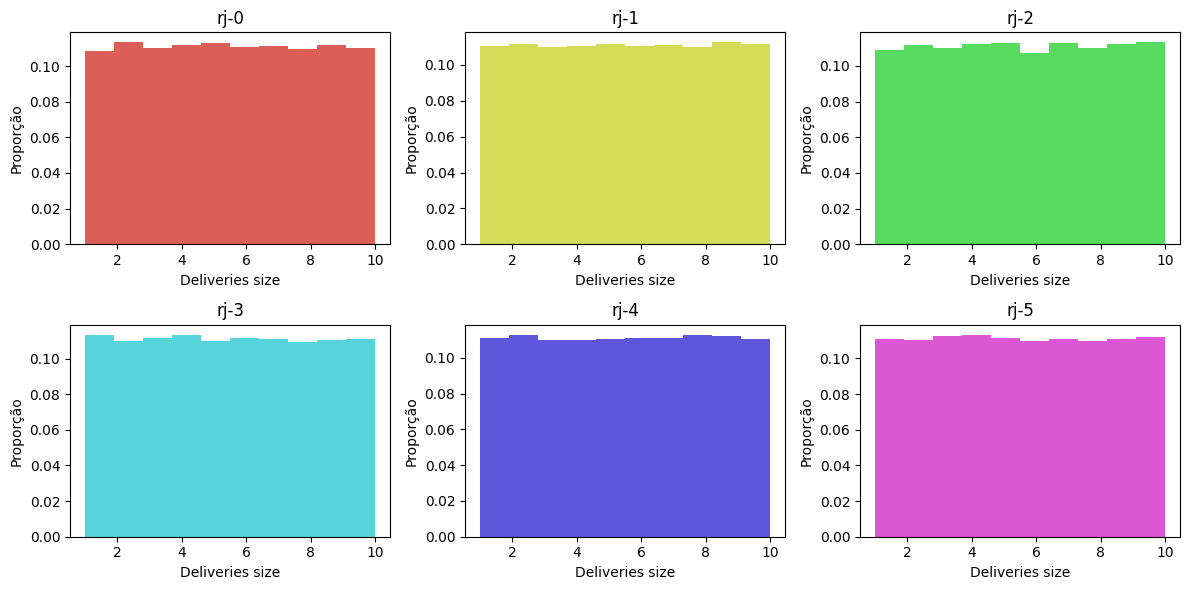

In [ ]:
fig, ax = plt.subplots(2,3)
fig.set_figheight(6)
fig.set_figwidth(12)
for i in range(0,6):
  plt.subplot(2,3,i+1)
  plt.hist(deliveries.query(f'region == "rj-{i}"')['delivery_size'],density=True, color =sns.hls_palette(l=0.6)[i],histtype='bar')
  plt.xlabel("Deliveries size")
  plt.ylabel("Proporção")
  plt.title(f"rj-{i}")
  fig.tight_layout()


 **Insight :**  a distribuição de tamanho das entregas é semelhante em todos os hubs. Ou seja, o delivery_size não é um critério relevante para atribuir uma entrega a um hub.

### 5\.3 Distribuição geográfica das entregas por hub

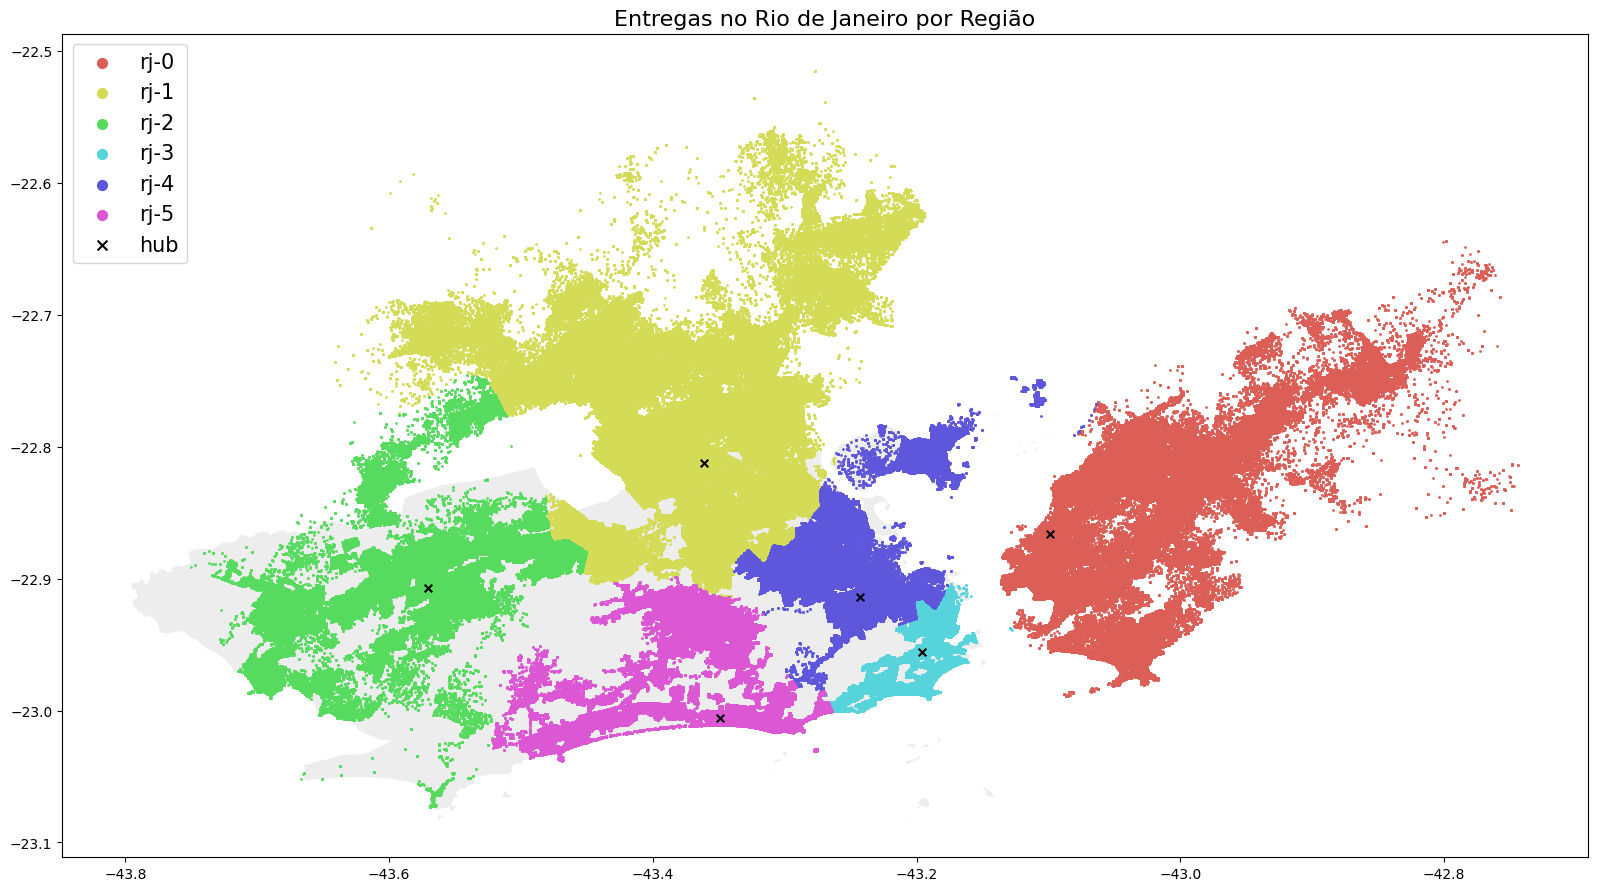

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(50/2.54, 50/2.54))

plt.title("Entregas no Rio de Janeiro por Região", fontdict={"fontsize": 16})
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

for i in range(0, 6):
    geo_deliveries_rj.query(f"region == 'rj-{i}'").plot(
        ax=ax, markersize=1, color=sns.hls_palette(l=0.6)[i], label=f"rj-{i}"
    )

geo_hub_rj.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

lgnd = plt.legend(prop={"size": 15}, loc="upper left")
for handle in lgnd.legend_handles:
    handle.set_sizes([50])

plt.show()


**Insight:** As entregas por hub estão bem divididas por região geográfica, visto que no mapa podemos ver as 6 regiões bem definidas sem aparentes interseções.

### 5\.4 Entregas com hubs mais próximos que o orginal

#### 5\.4.1 Quantidades

Algumas entregas podem não ter sido alocadas ao hub mais próximo do destino.Dessa forma, podemos contabilizar, por hub, quantas entregas possuem destino mais próximo a ele do que aos que foram designados inicialmente.

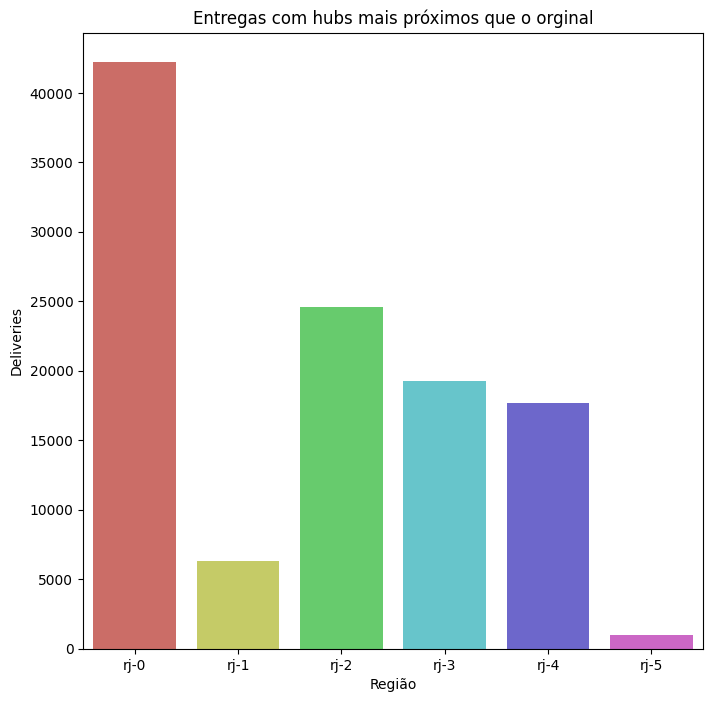

In [ ]:
fig, ax = plt.subplots(figsize = (8, 8))

for i in range(0,6):
  grafico = sns.barplot(deliveries_dist.query(f'region != nearest_hub & nearest_hub == "rj-{i}"')['nearest_hub'].value_counts(), color = sns.hls_palette(l=0.6)[i])
  grafico.set(title='Entregas com hubs mais próximos que o orginal', xlabel='Região', ylabel='Deliveries');

**Insight:** À primeira vista, temos mais de em torno de 100 mil entregas que poderiam ser otimizadas se tivessem sido alocadas em outro hub. Para entender melhor é necessário uma visão geográfica desses dados.

#### 5\.4.2 Contexto geográfico

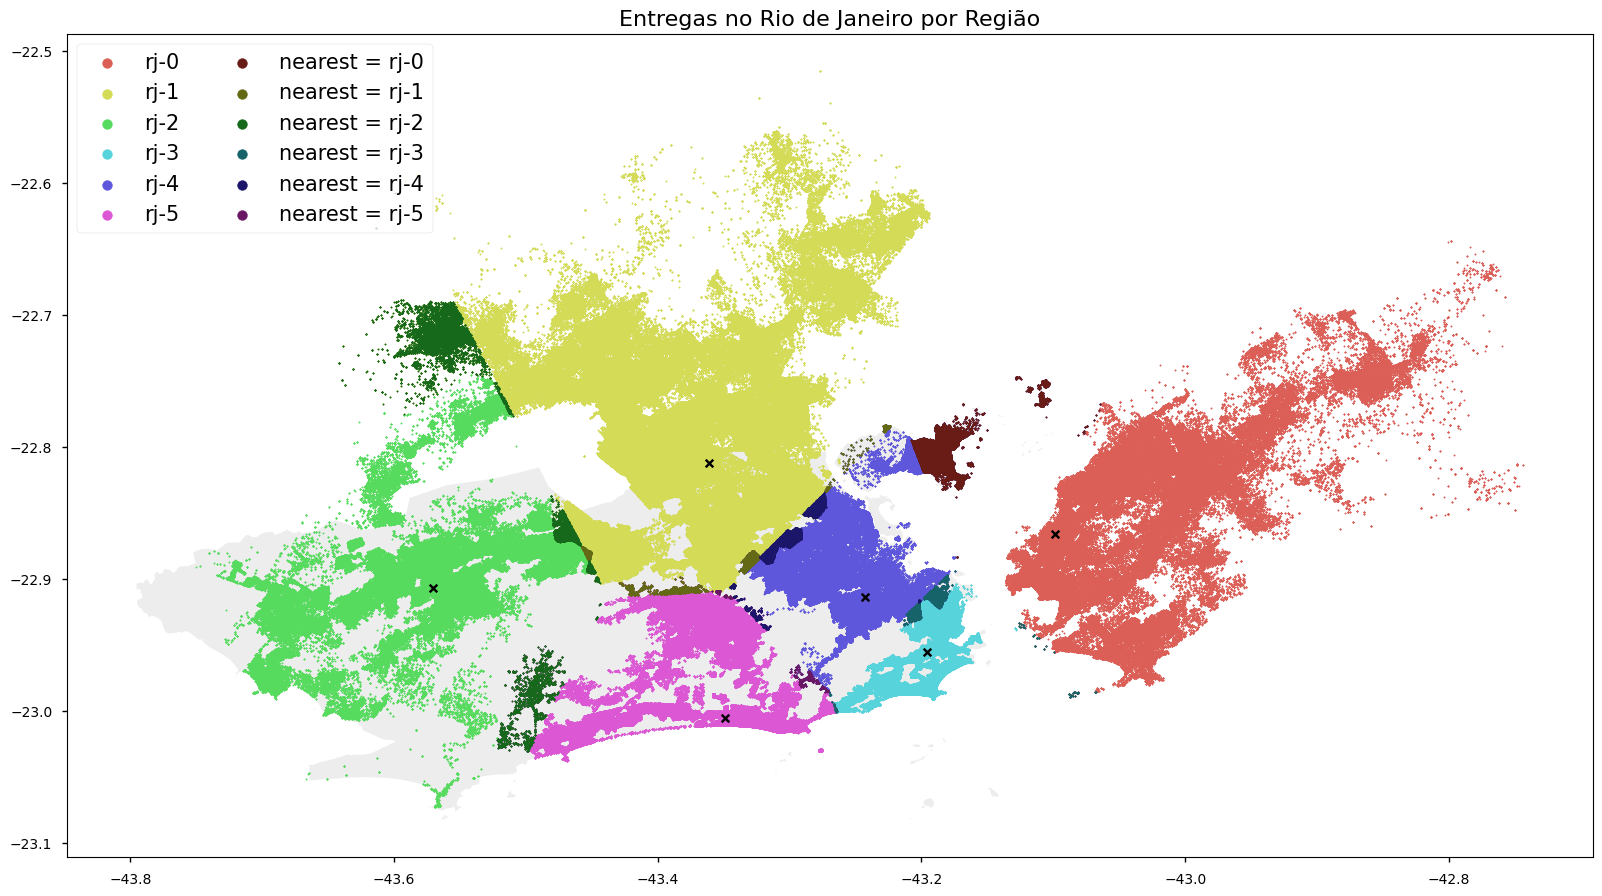

In [ ]:
plt.style.use('seaborn-v0_8-notebook')

%matplotlib inline

fig , ax = plt.subplots(figsize=(50/2.54, 50/2.54))

plt.title("Entregas no Rio de Janeiro por Região", fontdict={"fontsize": 16})
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

for i in range(0,6):
  geo_deliveries_rj.query(f"region == 'rj-{i}'").plot(ax = ax, markersize=1,color=sns.hls_palette(l=0.6)[i],  label=f"rj-{i}")

for i in range(0,6):
  geo_deliveries_rj.query(f'region != nearest_hub & nearest_hub == "rj-{i}"').plot(ax = ax ,markersize=1, color=sns.hls_palette(l=0.25)[i],  label=f"nearest = rj-{i}")


lgnd = plt.legend(prop={"size": 15} , loc = 'upper left', ncols = 2)
for handle in lgnd.legend_handles:
    handle.set_sizes([50])

geo_hub_rj.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

plt.show(fig)

### 5\.5 Distribuição de entregas por hub

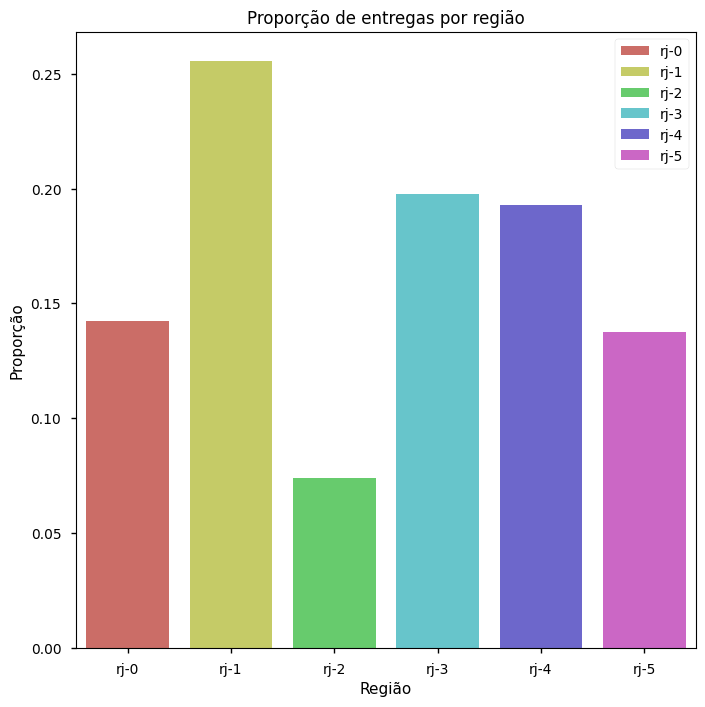

In [ ]:
fig, ax = plt.subplots(figsize = (8, 8))

data_region = pd.DataFrame(deliveries_dist[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data_region = data_region.rename(columns={'proportion': "region_percent"})

for i in range(0,6):
  grafico = sns.barplot(data=data_region.query(f"region == 'rj-{i}'"), x="region", y="region_percent", color= sns.hls_palette(l=0.6)[i],  label=f"rj-{i}")
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');

## 6\. Conclusão - Insights

Para entender melhor o cenário desse caso é também necessário uma visão geográfica mais detalhada da região a qual estamos analisando.

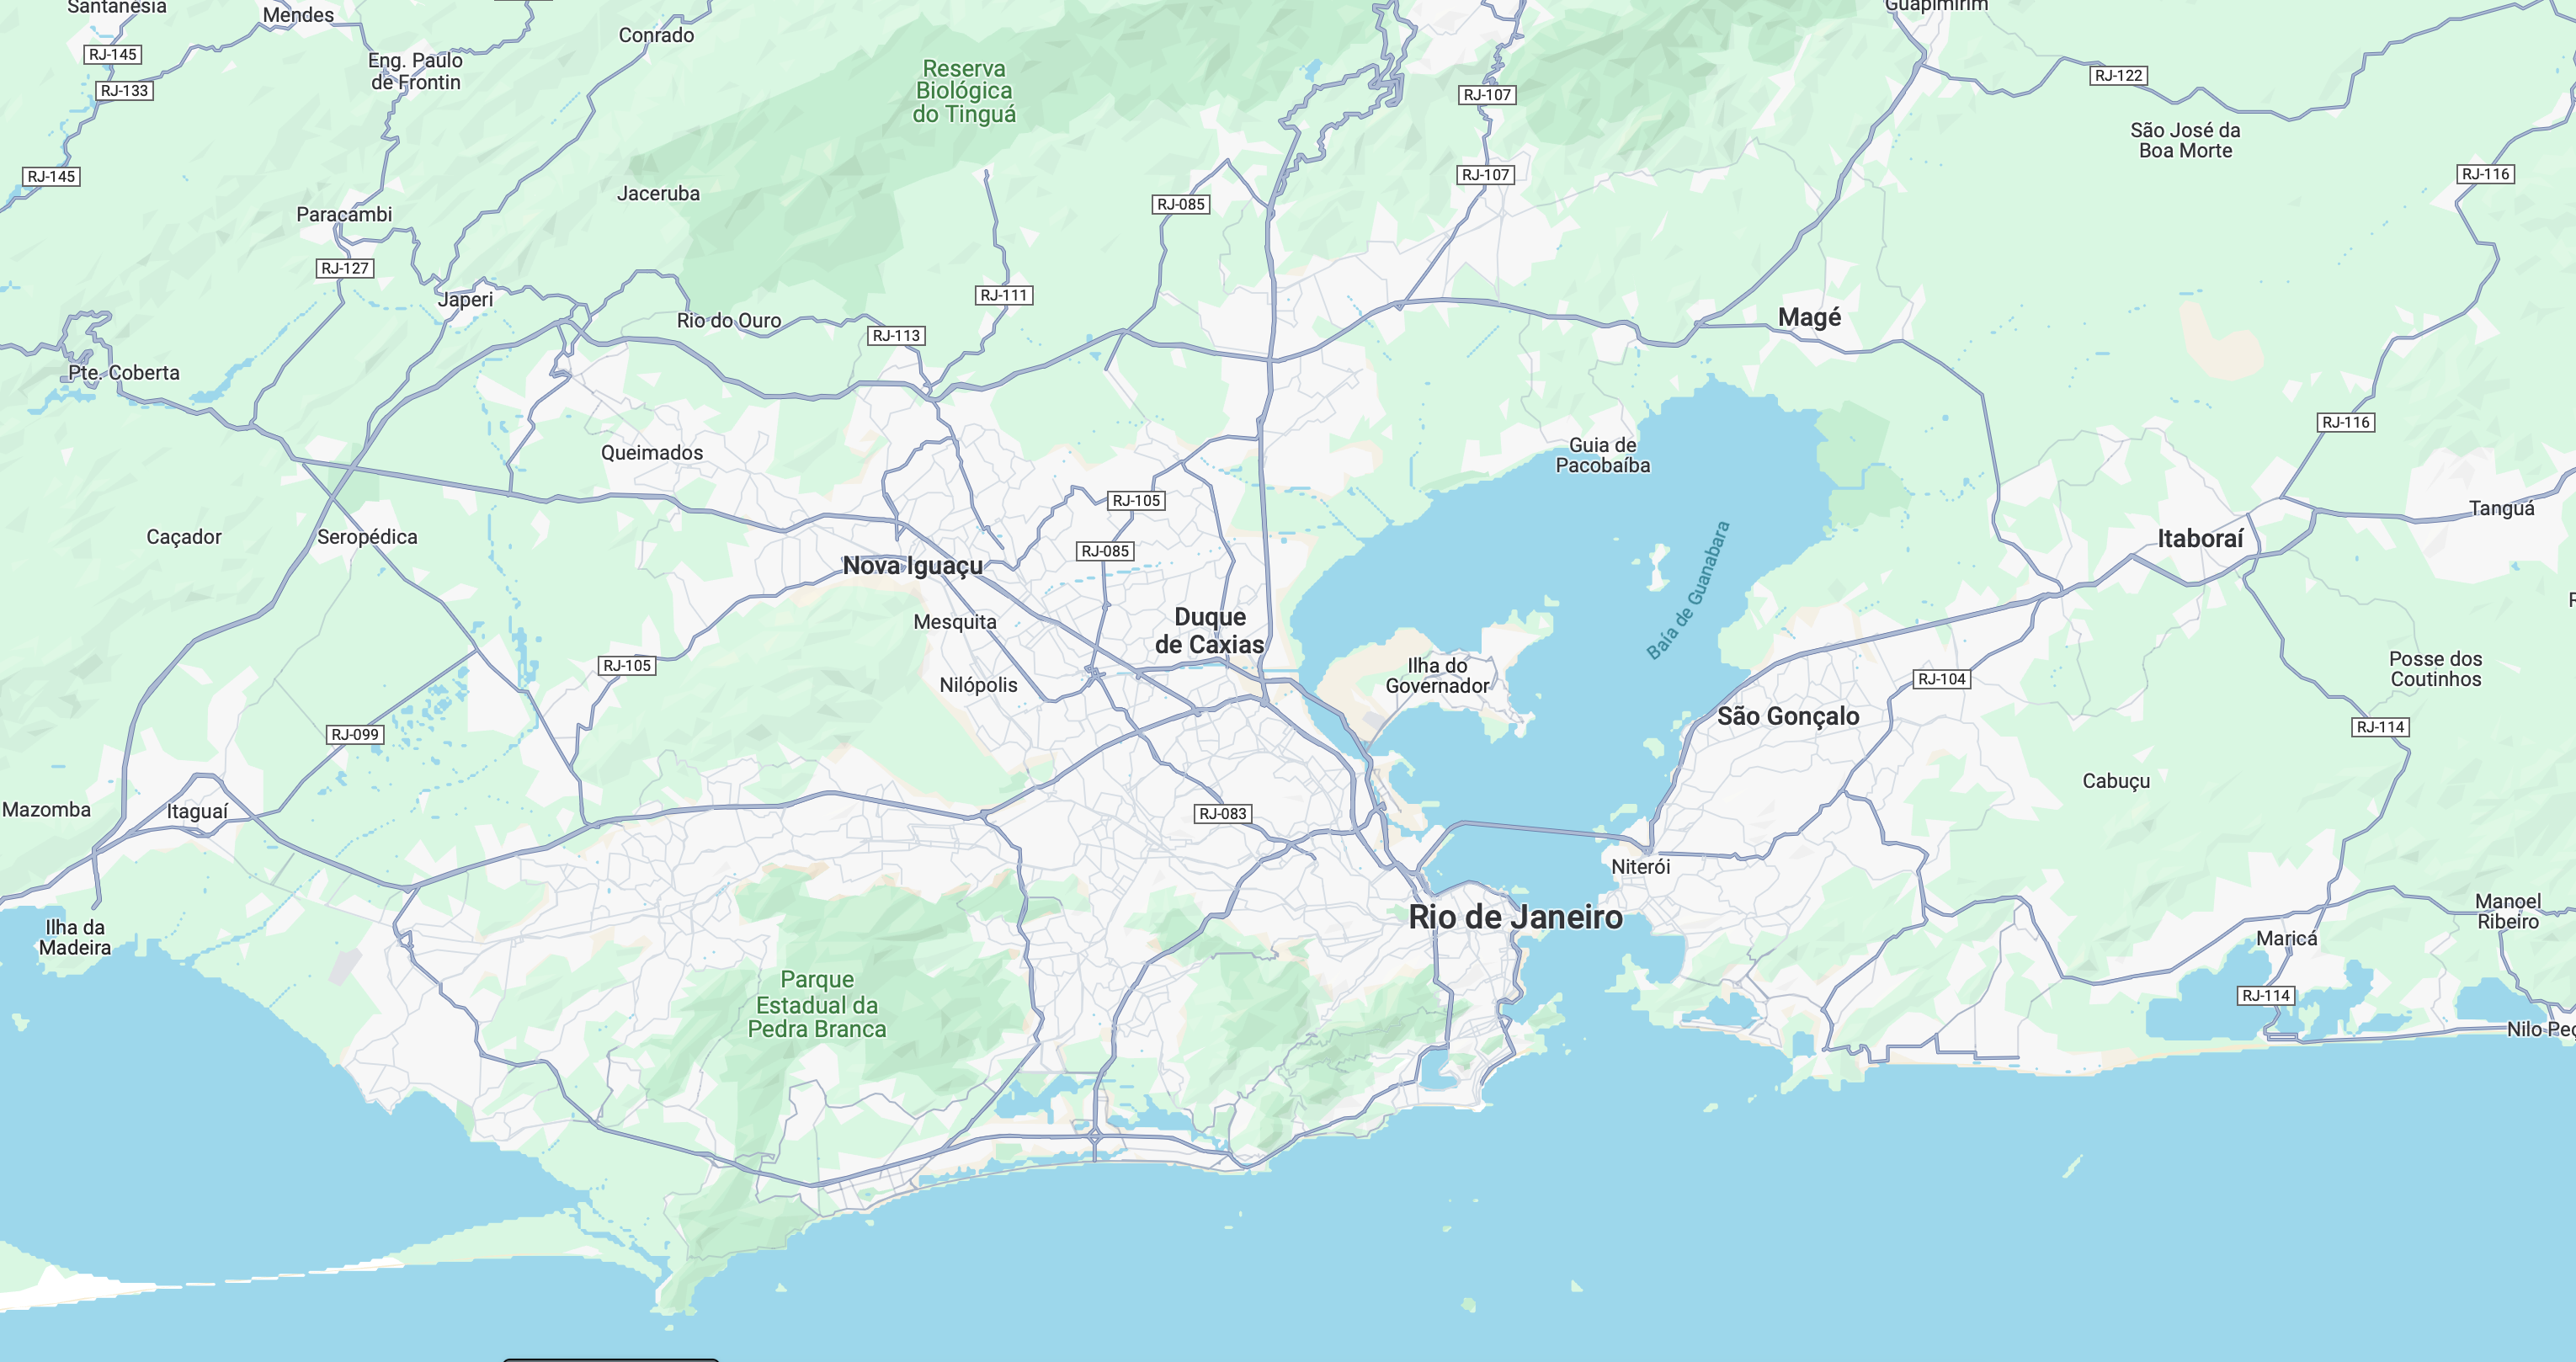

Dessa forma, a partir das análises que foram feitas com dados,é possível obter os seguintes insights:

*   É possível otimizar a distribuição das entregas nos hubs de acordo com a distância do hub ao destino. Para cada hub temos:

  *   **rj - 0** : Embora haja entregas cujo destino seja mais perto do hub rj - 0 que do orginal, a barreira física da Baía da Guanabara dificulta o trajeto do hub até esses destinos, que estão, em maioria, localizados na Ilha do Governador.Assim, não seria inteligente um realocação.
  *  **rj - 1** : Como esse hub é o que mais possui demanda de entrega, embora haja entregas cujo destino seja mais perto a esse que ao original, não seria inteligente sobrecarregar ainda mais esse centro de distribuição.Logo, também não seria inteligente um realocação.
  *  **rj - 2** : Possui o segundo maior número de entregas mais perto a esse hub que aos hubs orginais, além de ser o hub com menor demanda. Dessa forma, fazer a realocação dessas entregas diminuiria a demanda dos outros hubs    
  (rj-1, rj-5) que possuem número maior de entregas a serem feitas.
  *  **rj - 3**, **rj - 4** : Esses dois hubs apresentam características semelhantes, tanto na quantidade de entregas que são mais porximas do que do seu hub original, quanto na distribuição dos deliveries. Dessa forma, para otimizar o processo, as entregas mais próximas ao hub rj-4 e que pertencem ao hub rj-1 poderiam ser realocadas visando diminuir a maior demanda do hub rj-1. Paralelamente, visando balancear as demandas, as entregas mais próximas ao hub rj-3 e que pertencem ao hub rj-4 também poderiam ser realocadas.
  *  **rj - 5** : Possui o menor número de entregas. Dessa forma, fazer a realocação das entregas de outros hubs diminuiria a demanda dos outros hubs que possuem número maior de entregas a serem feitas e otimzaria o processo das entregas.



*   Além das realocações das entregas, outro fator analisado é a capacidade de veículos por hub. Como foi visto, todos os hubs posssui o mesmo valor de vehicle_capacity, embora apresentem cenários diferentes de demanda e área da região atendida. Distribuir os veículos de acordo com a demanda de acordo com esses critérios deve otimizar o processo das entregas. Um exemplo de realocação seria diminuir a quantidade de veículos no hub rg-5 (com menor área de abrangência e a menor demanda de entregas) para aumentar no hub rg-1 ((com maior área de abrangência e a maior demanda de entregas)).



